# Dropout and Batch Normalization

In this notebook we will implement Dropout and Batch Normalization. Batch Normalization both improves generalization and training speed. Dropout is considered to be a regularization technique.

Goal of this lab is to:

* Implement and understand basic aspects of Dropout
* Implement and understand basic aspects of Batch Normalization

References:
* "Dropout: A Simple Way to Prevent Neural Networks from Overfitting": https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

* "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift": https://arxiv.org/abs/1502.03167

# Setup

In [1]:
%load_ext autoreload
%autoreload 
%matplotlib inline

import json
import matplotlib as mpl
from src import fmnist_utils
from src.fmnist_utils import *

import torch
from torch.autograd.function import InplaceFunction
from torch.autograd import Variable
from itertools import repeat
from torch import nn
from torch import optim

/home/kg/miniconda3/envs/nn2018/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot(H):
    plt.title(max(H['test_acc']))
    plt.plot(H['acc'], label="acc")
    plt.plot(H['test_acc'], label="test_acc")
    plt.legend()

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (7, 7)
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12

(x_train, y_train), (x_test, y_test) = fmnist_utils.get_data(which="mnist")

# Whiteboard exercises

* (1.0, only this lab) Write equations for training and inference phase of Dropout. Explain inference mode of Dropout (see https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf, p 1531)
* (0.5, only this lab) Write equations for training and inference phase of Batch Normalization
* (0.5) Using either stability, or bias-variance perspective on generalization, argue why Dropout should prevent overfitting? 
* (0.5) Can Batch Normalization prevent vanishing gradient? How?
* (1.0) Yet another perspective on generalization in Deep Networks is through the lenses of memorization, see https://arxiv.org/abs/1611.03530. Do you think Dropout prevents or encourages memorization? 

(And any left-out exercise from the previous lab)

# Dropout

Note: We use MNIST to be able to quickly and in a stable way fit data, which makes it a good target for studying generalization.

## Exercise 1: Implement and show better generalization of Dropout

Answer the following questions using the provided starting code and model:

a) What train and test accuracy did you achieve without dropout?

b) What train and test accuracy did you achieve with dropout (best alpha)?

Hint: use torch.rand()

In [3]:
class BernoulliDropout(nn.Module):
    def __init__(self, alpha=1.0):
        super(BernoulliDropout, self).__init__()
        self.alpha = torch.Tensor([alpha])
        
    def forward(self, x):
        """
        Sample noise e ~ B(alpha)
        Multiply noise h = h_ * e
        """
        if self.train():
            return Variable(torch.rand(x.size()) > self.alpha).float() * x
        else:
            return (1 - self.alpha) * x

In [4]:
for alpha in [0.0, 0.1, 0.2, 0.5, 0.8]:
    input_dim = 784
    output_dim = 10
    # alpha = 0.00
    hidden_dims =  [50, 50, 50]
    model = torch.nn.Sequential()
    previous_dim = input_dim
    for id, D in enumerate(hidden_dims):
        model.add_module("dropout_{}".format(id), BernoulliDropout(alpha))
        model.add_module("linear_{}".format(id), torch.nn.Linear(previous_dim, D, bias=True))
        model.add_module("nonlinearity_{}".format(id), torch.nn.ReLU())
        previous_dim = D
    model.add_module("final_layer", torch.nn.Linear(D, output_dim, bias=True))

    loss = torch.nn.CrossEntropyLoss(size_average=True)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    H = train(loss=loss, model=model, x_train=x_train, y_train=y_train,
              x_test=x_test, y_test=y_test,
              optim=optimizer, batch_size=128, n_epochs=100)

    print("alpha:", alpha, "| train:", max(H['acc']), "| test:", max(H['test_acc']))

  0%|          | 0/100 [00:00<?, ?it/s]/home/kg/Projects/nn2018/lab/src/fmnist_utils.py:107: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return output.data[0]
  2%|▏         | 2/100 [00:00<00:08, 11.50it/s]

alpha: 0.0 | train: 1.0 | test: 0.852


  1%|          | 1/100 [00:00<00:10,  9.49it/s]

alpha: 0.1 | train: 0.998 | test: 0.851


  2%|▏         | 2/100 [00:00<00:08, 11.13it/s]

alpha: 0.2 | train: 0.982 | test: 0.862


  1%|          | 1/100 [00:00<00:12,  8.14it/s]

alpha: 0.5 | train: 0.823 | test: 0.705


100%|██████████| 100/100 [00:08<00:00, 12.33it/s]

alpha: 0.8 | train: 0.129 | test: 0.129


In [5]:
answers = {"a": "alpha: 0.0 | train: 1.0 | test: 0.842", "b": "alpha: 0.1 | train: 0.998 | test: 0.861"}
json.dump(answers, open("8_ex1.json", "w"))

  0%|          | 0/100 [00:00<?, ?it/s]/home/kg/Projects/nn2018/lab/src/fmnist_utils.py:107: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return output.data[0]
100%|██████████| 100/100 [00:08<00:00, 12.15it/s]


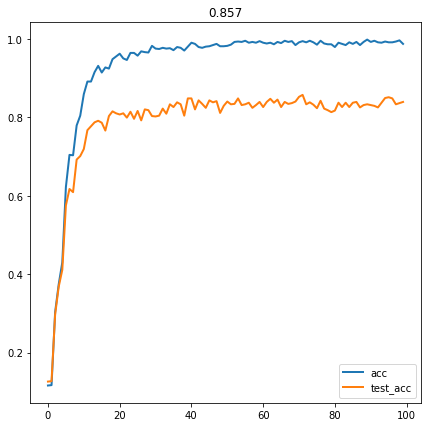

In [6]:
## Starting code

input_dim = 784
output_dim = 10
alpha = 0.1
hidden_dims =  [50, 50, 50]
model = torch.nn.Sequential()
previous_dim = input_dim
for id, D in enumerate(hidden_dims):
    model.add_module("dropout_{}".format(id), BernoulliDropout(alpha))
    model.add_module("linear_{}".format(id), torch.nn.Linear(previous_dim, D, bias=True))
    model.add_module("nonlinearity_{}".format(id), torch.nn.ReLU())
    previous_dim = D
model.add_module("final_layer", torch.nn.Linear(D, output_dim, bias=True))

loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
H = train(loss=loss, model=model, x_train=x_train, y_train=y_train,
          x_test=x_test, y_test=y_test,
          optim=optimizer, batch_size=128, n_epochs=100)

plot(H)

# Batch Normalization

## Exercise 2: Implement Batch Normalization

Answer the following questions using the provided starting code and model:

a) What train and test accuracy did you achieve without BN?

b) What train and test accuracy did you achieve with BN?

c) Can you use a larger LR in network with BN?

In [7]:
def batch_norm(input, running_mean, running_var, weight, bias,
    training, momentum, eps):
    
    if training:
        running_mean.set_(momentum * running_mean + (1 - momentum) * input.mean(0).data)
        running_var.set_(momentum * running_var + (1 - momentum) * input.var(0).data)
    
    if training:
        return weight * (input - Variable(input.mean(0).data)) / Variable(torch.sqrt(input.var(0).data + eps)) + bias
    else:
        return weight * (input - running_mean) / torch.sqrt(running_var + eps) + bias
    
class BatchNorm(nn.Module):

    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNorm, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.weight = nn.Parameter(torch.Tensor(num_features))
        self.bias = nn.Parameter(torch.Tensor(num_features))
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))
        self.reset_parameters()

    def reset_parameters(self):
        self.running_mean.zero_()
        self.running_var.fill_(1)
        self.weight.data.uniform_()
        self.bias.data.zero_()

    def _check_input_dim(self, input):
        return NotImplemented

    def forward(self, input):
        return batch_norm(
            input, self.running_mean, self.running_var, self.weight, self.bias,
            self.training, self.momentum, self.eps)

    def extra_repr(self):
        return '{num_features}, eps={eps}, momentum={momentum}, affine={affine}, ' \
               'track_running_stats={track_running_stats}'.format(**self.__dict__)


In [8]:
## Starting code

input_dim = 784
output_dim = 10
hidden_dims =  [50, 50, 50]
model = torch.nn.Sequential()
previous_dim = input_dim
for id, D in enumerate(hidden_dims):
    lin = torch.nn.Linear(previous_dim, D, bias=True)
    model.add_module("linear_{}".format(id), lin)
    #bn = BatchNorm(D)
    #model.add_module("bn_{}".format(id), bn)
    model.add_module("nonlinearity_{}".format(id), torch.nn.ReLU())
    previous_dim = D
model.add_module("final_layer", torch.nn.Linear(D, output_dim, bias=True))

loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=1.0, momentum=0.9)
H_nobn = train(loss=loss, model=model, x_train=x_train, y_train=y_train,
          x_test=x_test, y_test=y_test,
          optim=optimizer, batch_size=128, n_epochs=100)

print("no bn", "| train:", max(H_nobn['acc']), "| test:", max(H_nobn['test_acc']))

  0%|          | 0/100 [00:00<?, ?it/s]/home/kg/Projects/nn2018/lab/src/fmnist_utils.py:107: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return output.data[0]
100%|██████████| 100/100 [00:03<00:00, 25.01it/s]

no bn | train: 0.422 | test: 0.394


In [9]:
## Starting code

input_dim = 784
output_dim = 10
hidden_dims =  [50, 50, 50]
model = torch.nn.Sequential()
previous_dim = input_dim
for id, D in enumerate(hidden_dims):
    lin = torch.nn.Linear(previous_dim, D, bias=True)
    model.add_module("linear_{}".format(id), lin)
    bn = BatchNorm(D)
    model.add_module("bn_{}".format(id), bn)
    model.add_module("nonlinearity_{}".format(id), torch.nn.ReLU())
    previous_dim = D
model.add_module("final_layer", torch.nn.Linear(D, output_dim, bias=True))

loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=1.0, momentum=0.9)
H_bn = train(loss=loss, model=model, x_train=x_train, y_train=y_train,
          x_test=x_test, y_test=y_test,
          optim=optimizer, batch_size=128, n_epochs=100)

print("bn", "| train:", max(H_bn['acc']), "| test:", max(H_bn['test_acc']))

  0%|          | 0/100 [00:00<?, ?it/s]/home/kg/Projects/nn2018/lab/src/fmnist_utils.py:107: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return output.data[0]
100%|██████████| 100/100 [00:06<00:00, 16.14it/s]

bn | train: 1.0 | test: 0.838


In [10]:
answers = {"a": "bn | train: 1.0 | test: 0.847", "b": "no bn | train: 0.458 | test: 0.422", "c": "yes"}
json.dump(answers, open("8_ex2.json", "w"))

## Exercise 3: Does it really reduce internal drift?

Produce an experiment similar to Figure 1 in https://arxiv.org/pdf/1502.03167.pdf (you can use our data and neural network). 

<img width=200 src="https://github.com/gmum/nn2018/raw/master/lab/fig/8/fig1.png">

Result is just a figure, save it to 8_3.png.

In [11]:
def train_bn(model, loss, optim, 
          x_train, y_train, x_test, y_test, batch_size=100, n_epochs=10):
    """
    Trains given model on the FashionMNIST dataset.
    
    Returns
    -------
    history: dict
        History containing 'acc' and 'test_acc' keys.
    """
    torch.manual_seed(42) 
    n_examples = len(x_train)
    bn_act = nn.Sequential(*list(model.children())[:2])
    history = {"acc": [], "test_acc": [], "bn": []}
    for i in tqdm.tqdm(range(n_epochs), total=n_epochs):
        
        # Ugly way to shuffle dataset
        ids = np.random.choice(len(x_train), len(x_train), replace=False)
        x_train = torch.from_numpy(x_train.numpy()[ids])
        y_train = torch.from_numpy(y_train.numpy()[ids])
        
        cost = 0.
        num_batches = n_examples // batch_size
        for k in range(num_batches):
            start, end = k * batch_size, (k + 1) * batch_size
            cost += step(model, loss, optim, x_train[start:end], y_train[start:end])
            history['bn'].append(bn_act(Variable(x_train[start:end])))
        
        predY = predict(model, x_test)
        test_acc = np.mean(predY == y_test.numpy())
        history['test_acc'].append(test_acc)
 
        # Usually it is computed from per batch averages, but I compute
        # here using the whole train set to reduce level of noise in the learning curves
        predY = predict(model, x_train)
        train_acc = np.mean(predY == y_train.numpy())
        history['acc'].append(train_acc)
        
    return history

In [12]:
input_dim = 784
output_dim = 10
hidden_dims =  [50, 50, 50]
model = torch.nn.Sequential()
previous_dim = input_dim
for id, D in enumerate(hidden_dims):
    lin = torch.nn.Linear(previous_dim, D, bias=True)
    model.add_module("linear_{}".format(id), lin)
    bn = BatchNorm(D)
    model.add_module("bn_{}".format(id), bn)
    model.add_module("nonlinearity_{}".format(id), torch.nn.ReLU())
    previous_dim = D
model.add_module("final_layer", torch.nn.Linear(D, output_dim, bias=True))

loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=1.0, momentum=0.9)
H_bn = train_bn(loss=loss, model=model, x_train=x_train, y_train=y_train,
          x_test=x_test, y_test=y_test,
          optim=optimizer, batch_size=128, n_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]/home/kg/Projects/nn2018/lab/src/fmnist_utils.py:107: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return output.data[0]
100%|██████████| 100/100 [00:07<00:00, 14.03it/s]


In [13]:
#numpy.percentile(a, q, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)
np.percentile(H_bn['bn'][0].data.numpy(), [15, 50, 85], axis=0).mean(axis=1)
a = []
b = []
c = []
for i in range(len(H_bn['bn'])):
    a.append(np.percentile(H_bn['bn'][i].data.numpy(), [15, 50, 85], axis=0).mean(axis=1)[0])
    b.append(np.percentile(H_bn['bn'][i].data.numpy(), [15, 50, 85], axis=0).mean(axis=1)[1])
    c.append(np.percentile(H_bn['bn'][i].data.numpy(), [15, 50, 85], axis=0).mean(axis=1)[2])

In [14]:
def train_(model, loss, optim, 
          x_train, y_train, x_test, y_test, batch_size=100, n_epochs=10):
    """
    Trains given model on the FashionMNIST dataset.
    
    Returns
    -------
    history: dict
        History containing 'acc' and 'test_acc' keys.
    """
    torch.manual_seed(42) 
    n_examples = len(x_train)
    mod = nn.Sequential(*list(model.children())[:1])
    history = {"acc": [], "test_acc": [], "asd": []}
    for i in tqdm.tqdm(range(n_epochs), total=n_epochs):
        
        # Ugly way to shuffle dataset
        ids = np.random.choice(len(x_train), len(x_train), replace=False)
        x_train = torch.from_numpy(x_train.numpy()[ids])
        y_train = torch.from_numpy(y_train.numpy()[ids])
        
        cost = 0.
        num_batches = n_examples // batch_size
        for k in range(num_batches):
            start, end = k * batch_size, (k + 1) * batch_size
            cost += step(model, loss, optim, x_train[start:end], y_train[start:end])
            history['asd'].append(mod(Variable(x_train[start:end])))
        
        predY = predict(model, x_test)
        test_acc = np.mean(predY == y_test.numpy())
        history['test_acc'].append(test_acc)
 
        # Usually it is computed from per batch averages, but I compute
        # here using the whole train set to reduce level of noise in the learning curves
        predY = predict(model, x_train)
        train_acc = np.mean(predY == y_train.numpy())
        history['acc'].append(train_acc)
        
    return history

In [15]:
input_dim = 784
output_dim = 10
hidden_dims =  [50, 50, 50]
model = torch.nn.Sequential()
previous_dim = input_dim
for id, D in enumerate(hidden_dims):
    lin = torch.nn.Linear(previous_dim, D, bias=True)
    model.add_module("linear_{}".format(id), lin)
    #bn = BatchNorm(D)
    #model.add_module("bn_{}".format(id), bn)
    model.add_module("nonlinearity_{}".format(id), torch.nn.ReLU())
    previous_dim = D
model.add_module("final_layer", torch.nn.Linear(D, output_dim, bias=True))

loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=1.0, momentum=0.9)
H = train_(loss=loss, model=model, x_train=x_train, y_train=y_train,
          x_test=x_test, y_test=y_test,
          optim=optimizer, batch_size=128, n_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]/home/kg/Projects/nn2018/lab/src/fmnist_utils.py:107: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return output.data[0]
100%|██████████| 100/100 [00:04<00:00, 23.55it/s]


In [16]:
d = []
e = []
f = []
for i in range(len(H['asd'])):
    d.append(np.percentile(H['asd'][i].data.numpy(), [15, 50, 85], axis=0).mean(axis=1)[0])
    e.append(np.percentile(H['asd'][i].data.numpy(), [15, 50, 85], axis=0).mean(axis=1)[1])
    f.append(np.percentile(H['asd'][i].data.numpy(), [15, 50, 85], axis=0).mean(axis=1)[2])

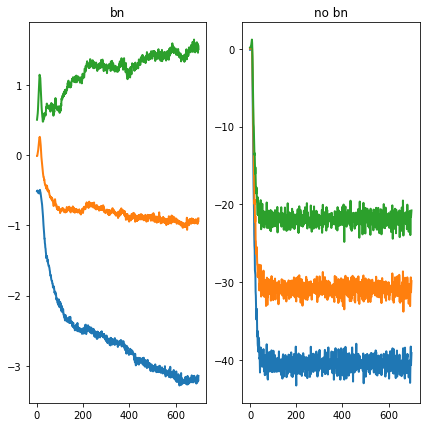

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(a)
ax1.plot(b)
ax1.plot(c)
ax1.set_title('bn')
ax2.plot(d)
ax2.plot(e)
ax2.plot(f)
ax2.set_title('no bn')
plt.savefig("8_ex3.png")